In [1]:
import cfe
import matplotlib.pyplot as plt

[2025年01月15日 12时14分35秒] INFO                                                                                 
                                          _____     _ _ ______    _       ______            _                      
                                         / ____|   | | |  ____|  | |     |  ____|          | |                     
                                        | |     ___| | | |__ __ _| |_ ___| |__  __  ___ __ | | ___  _ __ ___ _ __  
                                        | |    / _ \ | |  __/ _` | __/ _ \  __| \ \/ / '_ \| |/ _ \| '__/ _ \ '__| 
                                        | |___|  __/ | | | | (_| | ||  __/ |____ >  <| |_) | | (_) | | |  __/ |    
                                         \_____\___|_|_|_|  \__,_|\__\___|______/_/\_\ .__/|_|\___/|_|  \___|_|    
                                                                                     | |                           
                                                                              

构造数据

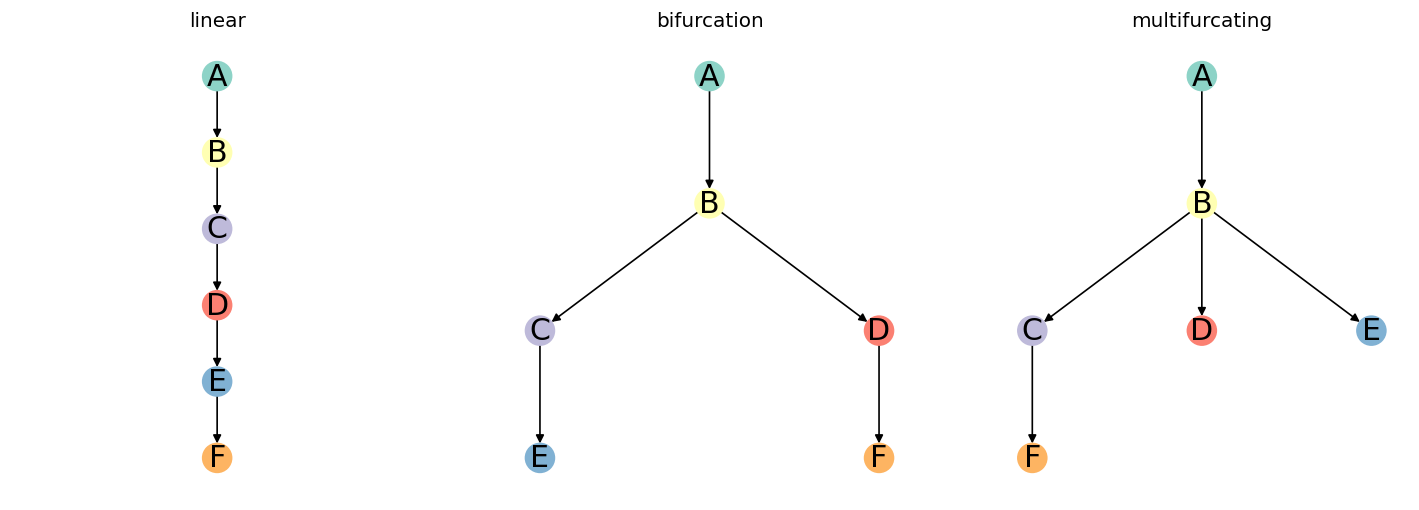

In [2]:
# 导入数据
milestone_netowrk_dict = cfe.data.topologies_with_same_n_milestones

# 封装轨迹
fadata_dict = {}
for id, milestone_netowrk in milestone_netowrk_dict.items():
    fadata = cfe.data.generate_trajectory(milestone_netowrk, id)
    fadata_dict[id] = fadata

# 可视化
n = len(fadata_dict)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for id, trajectory in fadata_dict.items():
    cfe.plot.plot_topology(trajectory, ax=ax[i], nx_draw_kwrags={"font_size": 18})
    ax[i].set_title(id)
    i += 1